# Load modules, …

In [1]:
%load_ext autoreload
%matplotlib inline
%load_ext autotime

In [2]:
%autoreload 2

time: 1.93 ms


In [3]:
from __future__ import division
import pandas as pd
import numpy as np
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt

import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import plotly.offline as py
import plotly.graph_objs as GO

import astropy
import os

from tools import convolution, tools
from tools.readtree import readtree as rt

import glob

py.init_notebook_mode()

matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (16, 9)

time: 3.3 s


In [4]:
halo_id = 82873

time: 1.72 ms


In [5]:
"""%%cython 

cimport numpy as np
import numpy as np
import itertools
from tqdm import tqdm

from cpython cimport bool"""

def load_tree(rt, halo_ids, nsteps=rt.nsteps):
    '''Build the tree for halo_id, then closes the rt descriptor using a reversed tree.
    Arguments:
    ----------
    rt: a readtree instance
    halo_ids: list-like of halos to build tree of
    nsteps: number of steps in the simulation
    
    Returns:
    --------
    halos: dict, containing for each step a dictionary of the halos, parents of the initial halo_ids
    '''
    halos = {step+1: {} for step in range(nsteps)}
    
    stop_now = False
    prev_step = nsteps+1
    
    new_halo_ids = set(halo_ids)
    halo_ids = set(halo_ids)
    
    counter = 1
    while True:
        counter += 1
        ( stop_now, halo_id, bushid, step, level,
         hosthalo, hostsub, nbsub, nextsub,
         nb_of_fathers, nb_of_sons,
         m, macc,
         px, py, pz,
         vx, vy, vz,
         lx, ly, lz,
         r, ra, rb, rc,
         ek, ep, et, spin ) = rt.iter_tree()
          
        if stop_now:
            break
    
        # if we just arrived to a new step, filter the halo that are the parents of prev halos
        # then reset the new_halo_ids and store it
        if prev_step == step + 1:
            
            # halo_ids is the previous one (made of parents)
            halo_ids = new_halo_ids
            # reset the "new_halo_ids" to the empty set
            new_halo_ids = set()
            
            prev_step = step
            
            # stop if no halo anymore
            if len(halo_ids) == 0:
                print("len(%s) ==0" % halo_ids)
                break

        # if at first row of steps
        if halo_id not in halo_ids:
            continue
        #else:
        #    print(halo_id, 'in', halo_ids, 'at step', step)

        # decorate the halo
        halo = {'data': {'mass': m, 
                         'macc': macc,
                         'pos': np.array([px, py, pz]),
                         'r': r
                        },
                'parents': []
               }

        # link to the fathers of the halo
        if nb_of_fathers > 0:
            id_fathers, m_fathers = rt.get_fathers(nb_of_fathers)
            halo['parents'] = id_fathers
            
            new_halo_ids.update(id_fathers)

        halos[step][halo_id] = halo
    rt.close_file()
    
    return halos

def relink(halos):
    # relink
    for step in halos.keys():
        #print('STEP: %s' % step)
        for id in halos[step]:
            unique_parents = np.unique(halos[step][id]['parents'])
            #print(r'    %s %s' % (id, unique_parents))
            new_parents = {p_id: halos[step-1][p_id] for p_id in halos[step][id]['parents'] if p_id > 0} if step > 1 else {}
            halos[step][id]['parents'] = new_parents
    return halos

time: 83.2 ms


In [6]:
def generate_tree(halos, rt, key='mass'):
    ''' Generate a tree representation of the halos
    Parameters:
    -----------
    halos: a dictionary of dictionaries halos[step][halo_id] containing the info of halo at step. The data of the halo is in halos[step][halo_id]['data'] and the parents
    are the id of the halo at the previous step and stored in halos[step][halo_id]['parents']
    rt: a readtree instance
    key: the key to use to generate the tree. Can be either 'mass', 'x', 'y' or 'z'
    
    Returns:
    --------
    ((Xe, Ye), (Xh, Yh)) where
    (Xe, Ye) are the positions of the edges (links between two halos) in mass-step coordinates
    (Xh, Yh) are the positions of the halos in mass-step coordinates
    '''
    # Positions of the halos
    halos_visited = set()
    Xh = []
    Yh = []
    # Edges between the halos
    edges_visited = set()
    Xe = []
    Ye = []

    if key is 'mass':
        getKey = lambda h, step: h['data']['mass']
    elif key in 'xyz':
        getKey = lambda h, step: h['data']['pos']['xyz'.index(key)] / rt.aexp[len(rt.aexp)-step]
    elif key is 'r':
        getKey = lambda h, step: h['data']['r']
    else:
        raise Exception('%s not in "mass", "x", "y", "z", "r".' % key)
        
    for step in halos:
        for halo_id in halos[step]:
            source = '%s-%s' % (step, halo_id)
            if source not in halos_visited:
                halos_visited.add(source)

                # add the position of the halo
                Xh += [getKey(halos[step][halo_id], step)]
                Yh += [step]

                for p in halos[step][halo_id]['parents']:
                    target = '%s-%s' % (step-1, p)
                    edge_name = '%s--%s' % (source, target)
                    if edge_name not in edges_visited:
                        edges_visited.add(edge_name)

                        # add the edge
                        Xe += [getKey(halos[step][halo_id], step),
                               getKey(halos[step-1][p], step-1), np.nan
                              ]

                        Ye += [step, step-1, np.nan] 
    return ((Xe, Ye), (Xh, Yh))

time: 42.1 ms


# Load inertia data

In [7]:
inertia_data = pd.read_csv('data/inertia_data.csv', index_col='id', engine='c')
inertia_data['vtheta_over_sigma'] = 1/inertia_data['sigma_over_vtheta']
inertia_data.head()

,mass,x,y,z,xx,xy,xz,yy,yz,zz,...,l1,l2,log(l0),log(l1),log(l2),log(sigma_over_vtheta),prod_li,log(prod_li),hlevel,vtheta_over_sigma
id,,,,,,,,,,,,,,,,,,,,,
1.0,2.447530e+10,0.054218,0.036724,0.032693,0.000006,9.182875e-07,1.416061e-06,0.000009,1.537712e-06,0.000007,...,0.002567,0.003197,-2.650979,-2.590637,-2.495290,NaN,1.832708e-08,-7.736907,1,NaN
2.0,7.453690e+11,0.037340,0.004005,0.011199,0.000050,-1.573558e-06,5.984283e-06,0.000061,8.054604e-07,0.000055,...,0.007670,0.007816,-2.168622,-2.115186,-2.107022,-0.055157,4.066017e-07,-6.390831,1,1.135421
3.0,1.762556e+10,0.049809,0.010437,0.000391,0.000004,-3.722408e-07,1.590209e-06,0.000008,9.675968e-07,0.000008,...,0.002746,0.003018,-2.754100,-2.561355,-2.520317,NaN,1.459578e-08,-7.835773,1,NaN
4.0,1.445129e+10,0.016944,0.043184,0.005668,0.000004,-1.076017e-06,3.801652e-07,0.000004,-5.158914e-07,0.000006,...,0.002193,0.002553,-2.767579,-2.658870,-2.593018,NaN,9.561660e-09,-8.019467,1,NaN
5.0,8.762659e+10,0.001566,0.046257,0.035597,0.000037,-4.088153e-06,-7.649228e-06,0.000009,2.248367e-06,0.000019,...,0.004033,0.006376,-2.545108,-2.394334,-2.195485,NaN,7.329478e-08,-7.134927,1,NaN


time: 3.37 s


# Compute the mergertree of all halos that have a tree

In [10]:
plt.close('all')

time: 2.74 ms


In [10]:
def savefig(fig, path):
    fig.savefig(path+'.png')
    fig.savefig(path+'.pdf')

time: 2.98 ms


In [11]:
fig = plt.figure(figsize=(16, 9))
#fig = plt.figure()
with matplotlib.style.context([]):
    for fname in tqdm(glob.glob('mergertrees/11.5_logm_12_both/halo_*.dat')):
        fig.clf()
        halo_id = int(fname.split('_')[-1].split('.dat')[0])

        rt.read_tree('mergertrees/11.5_logm_12_both/halo_%s.dat' % halo_id)
        halos = load_tree(rt, halo_ids=[halo_id])
        rhalos = relink(halos)

        step_root = 57
        (Xe, Ye), (Xh, Yh) = generate_tree(rhalos, rt, key='mass')

        # convert Yh in time
        def toTime(arr):
            return [rt.age_univ[e-1] if e > 0 else None for e in arr]
        Yh_in_t = toTime(Yh)
        Ye_in_t = toTime(Ye)

        #fig = plt.figure(figsize=(16, 9))
        ax = plt.gca()

        # Plot 
        ax.plot(np.array(Xe), Ye_in_t, '-', alpha=0.5, linewidth=0.5)
        ax.scatter(np.array(Xh), Yh_in_t)
        
        ax.set_xbound

        m, vtheta_o_sigma = inertia_data.loc[halo_id][['mass', 'vtheta_over_sigma']]
        logm = int(np.log10(m))
        mantissa = m / 10**logm
        ax.set_title(u'Halo n°%s, '% (halo_id) +r'$v_\theta/\sigma = %.2f $, $m = %.2f\ 10^{%s}\ M_\odot$' % ( vtheta_o_sigma, mantissa, logm))
        
        ax.set_ylabel('Temps [Gyr]')
        ax.set_xlabel('Mass [$10^{11}\ M_\odot$]')
        ax.set_xlim(left=0)
        fig.tight_layout()
        savefig(fig, '/home/cadiou/plots/mergertrees/11.5_logm_12.0_both/halo_%s' % halo_id)
plt.close('all')

100%|██████████| 22/22 [00:16<00:00,  1.47it/s]

time: 16.8 s


In [8]:
from tools.infos import read_infos
infos = dict()
for outputpath in glob.glob('/data52/Horizon-AGN/OUTPUT_DIR/output_*'):
    output = int(os.path.split(outputpath)[1].split('_')[1])
    
    infopath = os.path.join(outputpath, 'info_{:0>5}.txt'.format(output))
    infos[output] = read_infos(infopath)['infos']

time: 648 ms


  0%|          | 0/22 [00:00<?, ?it/s]


NameError: name 'savefig' is not defined

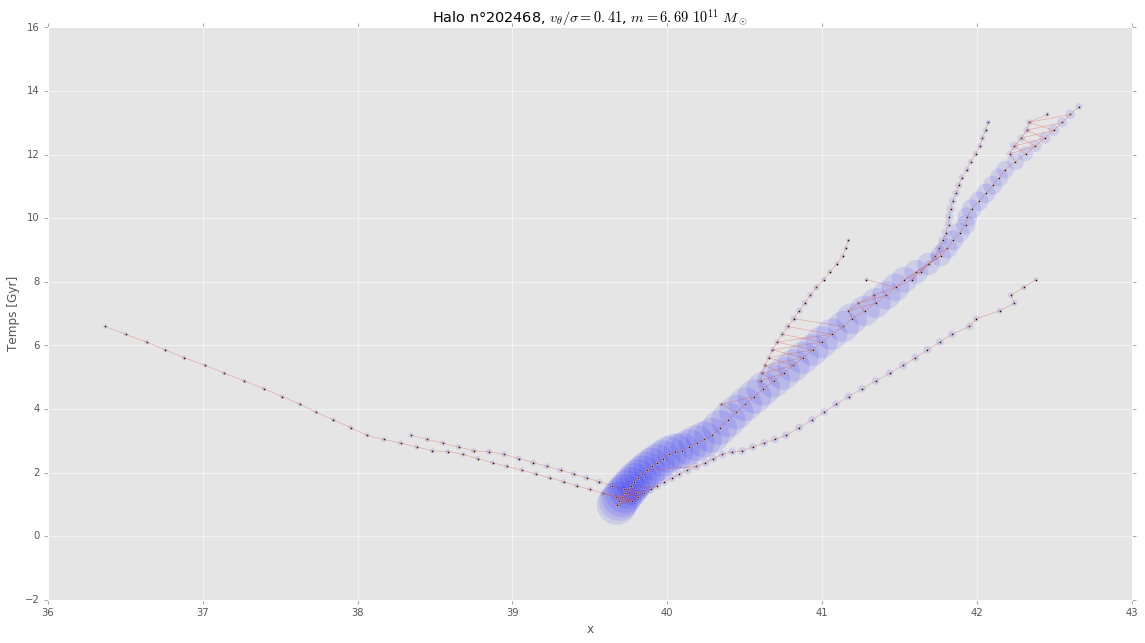

time: 2.59 s


In [9]:
fig = plt.figure(figsize=(16, 9))
#fig = plt.figure()
with matplotlib.style.context([]):
    for fname in tqdm(glob.glob('mergertrees/11.5_logm_12_both/halo_*.dat')[:]):
        fig.clf()
        halo_id = int(fname.split('_')[-1].split('.dat')[0])

        rt.read_tree('mergertrees/11.5_logm_12_both/halo_%s.dat' % halo_id)
        halos = load_tree(rt, halo_ids=[halo_id])
        rhalos = relink(halos)

        step_root = 57
        (Xe, Ye), (Xh, Yh) = generate_tree(rhalos, rt, key='x')
        _, (mass, Yh) = generate_tree(rhalos, rt, key='mass')

        mass = np.array(mass)
        # convert Yh in time
        def toTime(arr):
            return [rt.age_univ[e-1] if e > 0 else None for e in arr]
        Yh_in_t = toTime(Yh)
        Ye_in_t = toTime(Ye)

        #fig = plt.figure(figsize=(16, 9))
        ax = plt.gca()

        # Plot 
        ax.plot(np.array(Xe), Ye_in_t, '-', alpha=0.5, linewidth=0.5)
        ax.scatter(np.array(Xh), Yh_in_t, s=20*mass/mass.min(), alpha=0.1)
        ax.scatter(np.array(Xh), Yh_in_t, marker='.', c='black')
        
        ax.set_xbound

        m, vtheta_o_sigma = inertia_data.loc[halo_id][['mass', 'vtheta_over_sigma']]
        logm = int(np.log10(m))
        mantissa = m / 10**logm
        ax.set_title(u'Halo n°%s, '% (halo_id) +r'$v_\theta/\sigma = %.2f $, $m = %.2f\ 10^{%s}\ M_\odot$' % ( vtheta_o_sigma, mantissa, logm))
        
        ax.set_ylabel('Temps [Gyr]')
        ax.set_xlabel('x')
        fig.tight_layout()
        savefig(fig, '/home/cadiou/plots/mergertrees/11.5_logm_12.0_both/halo_%s_x' % halo_id)
plt.close('all')

In [ ]:
fig = plt.figure(figsize=(16, 9))
#fig = plt.figure()
with matplotlib.style.context([]):
    for fname in tqdm(glob.glob('mergertrees/11.5_logm_12_both/halo_*.dat')[:]):
        fig.clf()
        halo_id = int(fname.split('_')[-1].split('.dat')[0])

        rt.read_tree('mergertrees/11.5_logm_12_both/halo_%s.dat' % halo_id)
        halos = load_tree(rt, halo_ids=[halo_id])
        rhalos = relink(halos)

        step_root = 57
        (Xex, Ye), (Xhx, Yh) = generate_tree(rhalos, rt, key='x')
        (Xey, Ye), (Xhy, Yh) = generate_tree(rhalos, rt, key='y')
        (Xez, Ye), (Xhz, Yh) = generate_tree(rhalos, rt, key='z')
        _, (radii, _) = generate_tree(rhalos, rt, key='r')

        # convert Yh in time
        def toTime(arr):
            return [rt.age_univ[e-1] if e > 0 else None for e in arr]
        Yh_in_t = toTime(Yh)
        Ye_in_t = toTime(Ye)

        #fig = plt.figure(figsize=(16, 9))
        ax = fig.add_subplot(111, projection='3d')

        # Plot 
        #plt.set_cmap('viridis')
        # get radii replacing None by NaNs
        radii = np.array(radii)
        #ax.plot(np.array(Xex), np.array(Xey), Ye_in_t, '-', alpha=0.5, linewidth=0.5)
        sc = ax.scatter(np.array(Xhx), np.array(Xhy), Yh_in_t, marker='o', s=20*radii/radii.min(), alpha=0.1, c=Yh_in_t)
        ax.scatter(np.array(Xhx), np.array(Xhy), Yh_in_t, marker='.', c='black')
        ymin, ymax = ax.get_ylim()
        xmin, xmax = ax.get_xlim()
        zmin, zmax = ax.get_zlim()
        
        
        # isometric
        D = np.max([ymax - ymin, xmax - xmin]) / 2
        centers = np.array([xmin+xmax, ymin+ymax, zmin+zmax]) / 2
        xmin, ymin, _ = centers - D
        xmax, ymax, _ = centers + D
        
        
        ax.scatter(np.array(Xhx), np.ones_like(Xhy)*ymax, Yh_in_t, c='grey', marker='.')
        ax.scatter(np.ones_like(Xhx)*xmin, np.array(Xhy), Yh_in_t, c='grey', marker='.')
        ax.scatter(np.array(Xhx), np.array(Xhy), zmin, c='grey', marker='.')
        
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
        ax.set_zlim(zmin, zmax)

        m, vtheta_o_sigma = inertia_data.loc[halo_id][['mass', 'vtheta_over_sigma']]
        logm = int(np.log10(m))
        mantissa = m / 10**logm
        ax.set_title(u'Halo n°%s, '% (halo_id) +r'$v_\theta/\sigma = %.2f $, $m = %.2f\ 10^{%s}\ M_\odot$' % ( vtheta_o_sigma, mantissa, logm))
        
        ax.set_zlabel('Temps [Gyr]')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        cb = fig.colorbar(sc)
        cb.set_label('Temps [Gyr]')
        fig.tight_layout()
        savefig(fig, '/home/cadiou/plots/mergertrees/11.5_logm_12.0_both/halo_%s_xy' % halo_id)
plt.close('all')

100%|██████████| 22/22 [00:54<00:00,  2.00s/it]

time: 55 s


In [ ]:
fig = plt.figure(figsize=(16, 9))
#fig = plt.figure()
with matplotlib.style.context([]):
    for fname in tqdm(glob.glob('mergertrees/11.5_logm_12_both/halo_*.dat')[:]):
        fig.clf()
        halo_id = int(fname.split('_')[-1].split('.dat')[0])

        rt.read_tree('mergertrees/11.5_logm_12_both/halo_%s.dat' % halo_id)
        halos = load_tree(rt, halo_ids=[halo_id])
        rhalos = relink(halos)

        step_root = 57
        (Xex, Ye), (Xhx, Yh) = generate_tree(rhalos, rt, key='x')
        (Xey, Ye), (Xhy, Yh) = generate_tree(rhalos, rt, key='y')
        (Xez, Ye), (Xhz, Yh) = generate_tree(rhalos, rt, key='z')
        _, (radii, _) = generate_tree(rhalos, rt, key='r')

        # convert Yh in time
        def toTime(arr):
            return [rt.age_univ[e-1] if e > 0 else None for e in arr]
        Yh_in_t = toTime(Yh)
        Ye_in_t = toTime(Ye)

        #fig = plt.figure(figsize=(16, 9))
        ax = fig.add_subplot(111, projection='3d')

        # Plot 
        #plt.set_cmap('viridis')
        # get radii replacing None by NaNs
        radii = np.array(radii)
        #ax.plot(np.array(Xex), np.array(Xey), Ye_in_t, '-', alpha=0.5, linewidth=0.5)
        sc = ax.scatter(np.array(Xhx), np.array(Xhy), np.array(Xhz), marker='o', s=20*radii/radii.min(), alpha=0.1, c=Yh_in_t)
        ax.scatter(np.array(Xhx), np.array(Xhy), np.array(Xhz), marker='.', c='black')
        ymin, ymax = ax.get_ylim()
        xmin, xmax = ax.get_xlim()
        zmin, zmax = ax.get_zlim()
        
        D = np.max([ymax - ymin, xmax - xmin, zmax - zmin]) / 2
        centers = np.array([xmin+xmax, ymin+ymax, zmin+zmax]) / 2
        xmin, ymin, zmin = centers - D
        xmax, ymax, zmax = centers + D
        
        ax.scatter(np.array(Xhx), np.ones_like(Xhy)*ymax, Xhz, c='grey', marker='.')
        ax.scatter(np.ones_like(Xhx)*xmin, np.array(Xhy), Xhz, c='grey', marker='.')
        ax.scatter(np.array(Xhx), np.array(Xhy), zmin, c='grey', marker='.')
        
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
        ax.set_zlim(zmin, zmax)

        m, vtheta_o_sigma = inertia_data.loc[halo_id][['mass', 'vtheta_over_sigma']]
        logm = int(np.log10(m))
        mantissa = m / 10**logm
        ax.set_title(u'Halo n°%s, '% (halo_id) +r'$v_\theta/\sigma = %.2f $, $m = %.2f\ 10^{%s}\ M_\odot$' % ( vtheta_o_sigma, mantissa, logm))
        
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        
        cb = fig.colorbar(sc)
        cb.set_label('Temps [Gyr]')
        fig.tight_layout()
        savefig(fig, '/home/cadiou/plots/mergertrees/11.5_logm_12.0_both/halo_%s_xyz' % halo_id)

 36%|███▋      | 8/22 [00:24<00:48,  3.48s/it]

In [ ]:
#matplotlib.style.reload_library()
plt.close('all')

# Hey you, this is the mergertree of a galaxy!

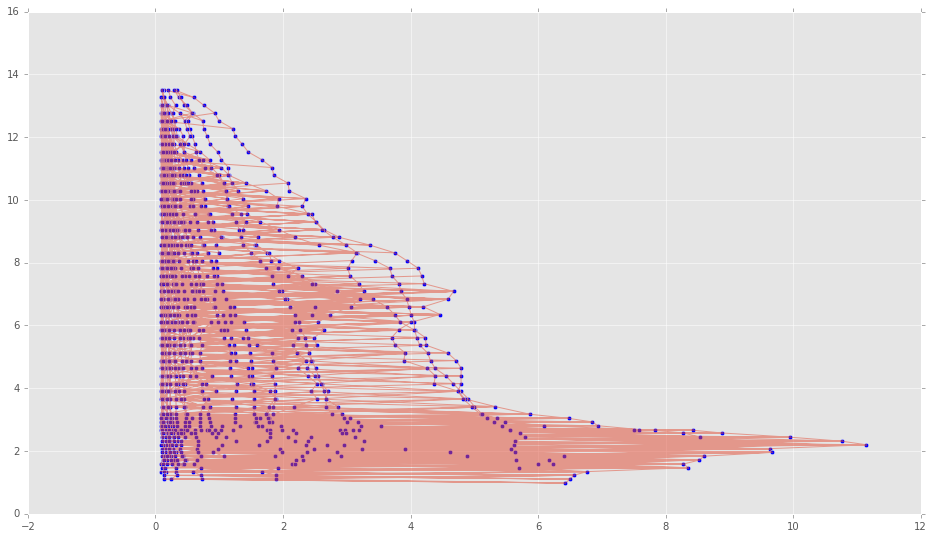

In [17]:
fig = plt.figure(figsize=(16, 9))
ax = plt.gca()

# Plot 
ax.plot(Xe, Ye_in_t, '-', alpha=0.5)
ax.scatter(Xh, Yh_in_t)

#py.iplot_mpl(plt.gcf())

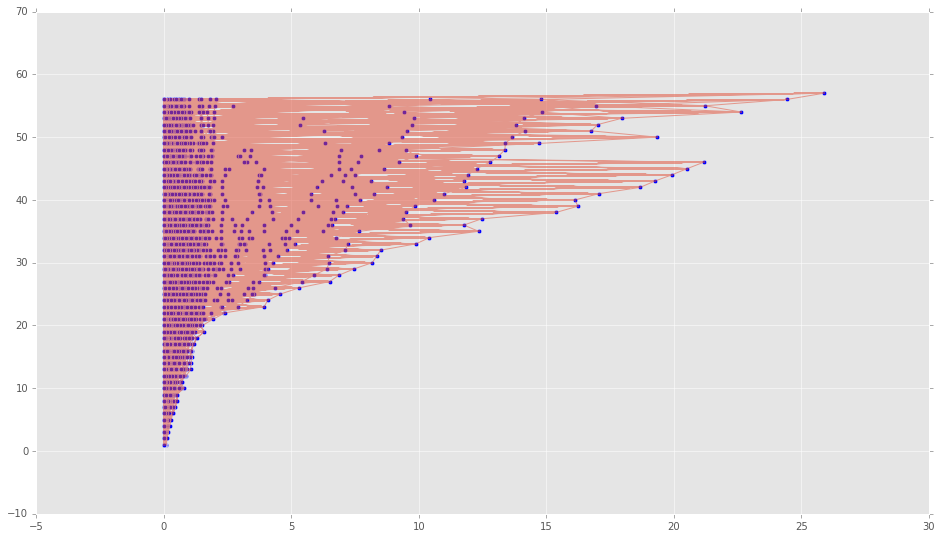

In [18]:
Xe_nan = [e if e is not None else np.nan for e in Xe]
Ye_in_t_nan = [e if e is not None else np.nan for e in Ye_in_t]

fig = plt.figure(figsize=(16, 9))
ax = plt.gca()

# Plot 
ax.plot(Xe, Ye, '-', alpha=0.5)
ax.scatter(Xh, Yh)

#py.iplot_mpl(plt.gcf())